In [1]:
import tensorflow as tf
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class NodeLookup(object):
    def __init__(self):
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)
        
    def load(self, label_lookup_path, uid_lookup_path):
        # 加载分类字符转n*******对应各分类名称的文件   uuid---->classname
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human={}
        # 一行一行读取数据
        for line in proto_as_ascii_lines:
            #去掉换行符
            line = line.strip('\n')
            #tab键分割
            parsed_items = line.split('\t')
            uid = parsed_items[0]
            human_string = parsed_items[1]
            uid_to_human[uid] = human_string
#         print(uid_to_human)
            
        # 加载分类字符串n*******对应分类编号1-1000的文件  classId---->uuid
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}
        for line in proto_as_ascii:
            if line.strip().startswith('target_class:'):
                target_class = int(line.strip().split(':')[1])
            elif line.strip().startswith('target_class_'):
                target_class_string = line.strip().split(':')[1].strip()
                node_id_to_uid[target_class] = target_class_string[1:-1]
#         print(node_id_to_uid)
        
        # 建立分类编号 1-1000 与对应分类名称的映射关系  classId---->classname
        node_id_to_name = {}
        for target_class,target_class_string in node_id_to_uid.items():
            classdesc = uid_to_human[target_class_string]
            node_id_to_name[target_class] = classdesc
        
        return node_id_to_name
    
    # 传入分类编号1-1000 返回分类名称
    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]

In [3]:
tf.reset_default_graph()
# 创建一个图来存放google训练好的模型
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb','rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def,name="")   #这个name默认="import" 类似加了 with.name_scope("import")

Instructions for updating:
Use tf.gfile.GFile.


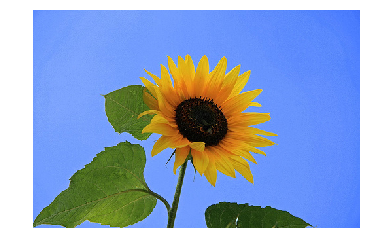

daisy (probability = 0.95406)
bee (probability = 0.00775)
vase (probability = 0.00209)
pot, flowerpot (probability = 0.00163)
picket fence, paling (probability = 0.00122)


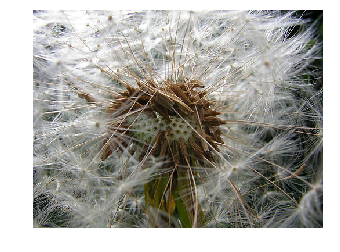

sea urchin (probability = 0.29418)
lionfish (probability = 0.19364)
sea anemone, anemone (probability = 0.10064)
cardoon (probability = 0.08423)
puffer, pufferfish, blowfish, globefish (probability = 0.03266)


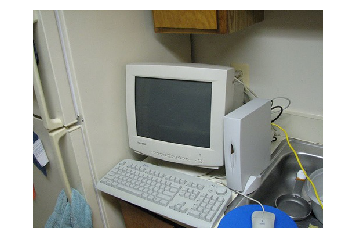

screen, CRT screen (probability = 0.32239)
desktop computer (probability = 0.25799)
computer keyboard, keypad (probability = 0.11673)
mouse, computer mouse (probability = 0.10105)
desk (probability = 0.06971)


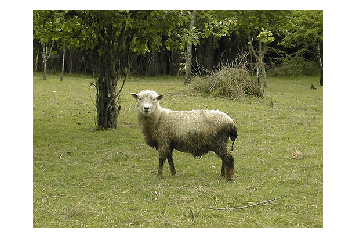

ram, tup (probability = 0.70410)
bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis (probability = 0.07976)
llama (probability = 0.00946)
kelpie (probability = 0.00575)
ibex, Capra ibex (probability = 0.00411)


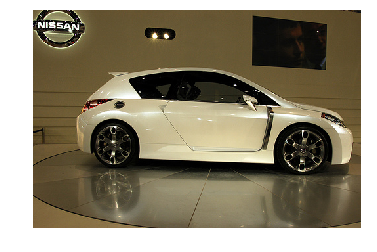

sports car, sport car (probability = 0.91007)
car wheel (probability = 0.02678)
convertible (probability = 0.01674)
racer, race car, racing car (probability = 0.00425)
grille, radiator grille (probability = 0.00385)


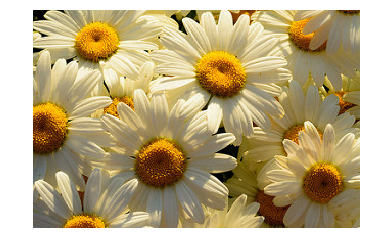

daisy (probability = 0.99661)
speedboat (probability = 0.00030)
mitten (probability = 0.00008)
bee (probability = 0.00006)
cradle (probability = 0.00004)


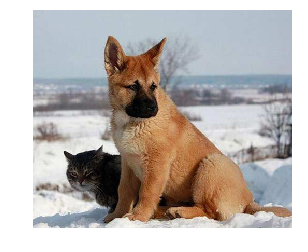

dingo, warrigal, warragal, Canis dingo (probability = 0.34871)
German shepherd, German shepherd dog, German police dog, alsatian (probability = 0.15934)
red wolf, maned wolf, Canis rufus, Canis niger (probability = 0.12121)
malinois (probability = 0.02796)
dhole, Cuon alpinus (probability = 0.01576)


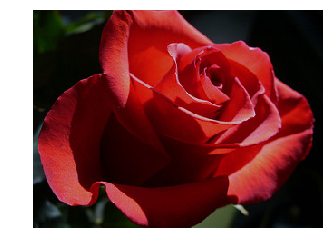

picket fence, paling (probability = 0.16607)
vase (probability = 0.13261)
bee (probability = 0.10441)
coral fungus (probability = 0.07683)
hummingbird (probability = 0.06724)


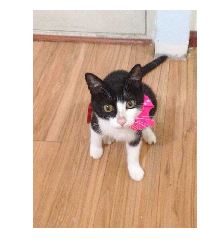

tabby, tabby cat (probability = 0.26538)
doormat, welcome mat (probability = 0.11180)
swab, swob, mop (probability = 0.06126)
Egyptian cat (probability = 0.04704)
tiger cat (probability = 0.03634)


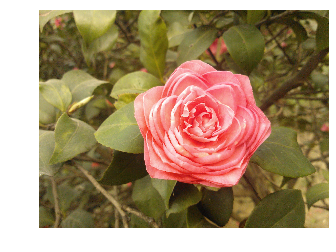

stinkhorn, carrion fungus (probability = 0.06766)
hip, rose hip, rosehip (probability = 0.04718)
wool, woolen, woollen (probability = 0.02871)
pot, flowerpot (probability = 0.02582)
knot (probability = 0.02453)


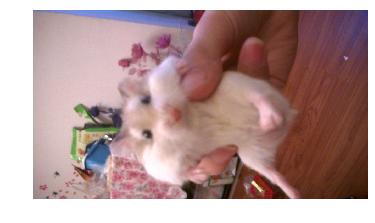

Angora, Angora rabbit (probability = 0.49486)
wood rabbit, cottontail, cottontail rabbit (probability = 0.07696)
dishwasher, dish washer, dishwashing machine (probability = 0.04046)
guinea pig, Cavia cobaya (probability = 0.03959)
hamster (probability = 0.03708)


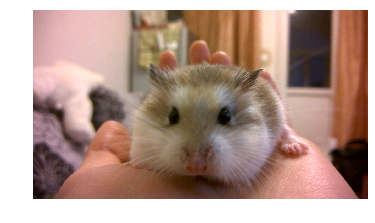

hamster (probability = 0.79670)
broccoli (probability = 0.00398)
corn (probability = 0.00214)
guinea pig, Cavia cobaya (probability = 0.00095)
window shade (probability = 0.00095)


In [4]:
node_lookup = NodeLookup()

with tf.Session() as sess:
    # 拿到softmax的op
    # 'softmax:0'这个名字，可以在网络中找到这个节点，它的名字就'(softmax)',
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    #print([node.name for node in sess.graph.as_graph_def().node])
    #root 目标根目录
    #dirs 子目录
    #files 子文件
    for root,dirs,files in os.walk('inception_model/images/'):
        for file in files:
            image_path = os.path.join(root, file)
            image_data = tf.gfile.FastGFile(image_path,'rb').read()
            # 运行softmax节点，向其中feed值
            # 可以在网络中找到这个名字，DecodeJpeg/contents，
            # 据此可以发现，根据名字取网络中op时，如果其名字带括号，就用括号内的名字，如果不带括号，就用右上角介绍的名字。
            # 而带个0，是默认情况，如果网络中出现同名节点，这个编号会递增
            predictions = sess.run(softmax_tensor,{'DecodeJpeg/contents:0':image_data})
            #上一行的输出结果predictions，是二维的，合并成一围
            predictions = np.squeeze(predictions)# 把结果转化为1维数据,消除掉batch_size维度

            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

            # 排序,argsort是小->大的顺序，
            #1. predictions.argsort()[-5:][::-1]    [-5]是取最后5个数据，[::-1]是逆序  
            #2.(-predictions).argsort()[:5]        也可以先对predictions*-1最大就变成了最小， 然后取前面5个值
            #3  predictions.argsort()[:-6:-1]      直接右切
            top_k = predictions.argsort()[:-6:-1]
            for node_id in top_k:
                human_string = node_lookup.id_to_string(node_id)
                score = predictions[node_id]
                print('%s (probability = %.5f)' % (human_string, score))